In [58]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Original Data

In [59]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True)
    }

    # Initialize the model with the current hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Perform cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

[I 2024-08-28 22:36:34,199] A new study created in memory with name: no-name-f5c64b00-b2f3-4ade-b228-24274a8890ad
[I 2024-08-28 22:36:34,379] Trial 0 finished with value: 0.7603909465020576 and parameters: {'n_estimators': 180, 'max_depth': 4, 'learning_rate': 0.21701291516036117, 'subsample': 0.5240234905263754, 'colsample_bytree': 0.9331257930826538, 'gamma': 4.459027267184904, 'lambda': 1.7047819841657104e-06, 'alpha': 5.402001050048058}. Best is trial 0 with value: 0.7603909465020576.
[I 2024-08-28 22:36:34,558] Trial 1 finished with value: 0.7852880658436213 and parameters: {'n_estimators': 141, 'max_depth': 10, 'learning_rate': 0.22398774096846863, 'subsample': 0.7650124446219291, 'colsample_bytree': 0.8089326668982024, 'gamma': 1.4372401130638823, 'lambda': 3.8514054107118414e-08, 'alpha': 9.106772515619163e-05}. Best is trial 1 with value: 0.7852880658436213.
[I 2024-08-28 22:36:34,816] Trial 2 finished with value: 0.7935699588477366 and parameters: {'n_estimators': 291, 'max_d

Best hyperparameters:  {'n_estimators': 178, 'max_depth': 2, 'learning_rate': 0.031575181331799644, 'subsample': 0.5959379808962455, 'colsample_bytree': 0.5619807267798064, 'gamma': 2.1481487704488127, 'lambda': 5.383695324215395e-06, 'alpha': 9.143040436146278e-07}


In [61]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [62]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()


In [63]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()

In [64]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

In [65]:
#test the model with the best hyperparameters
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

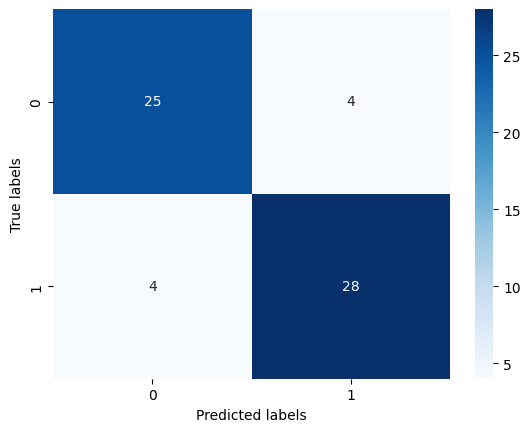

In [66]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [67]:

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print(classification_report(y_test, y_pred))


Accuracy:  0.8688524590163934
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



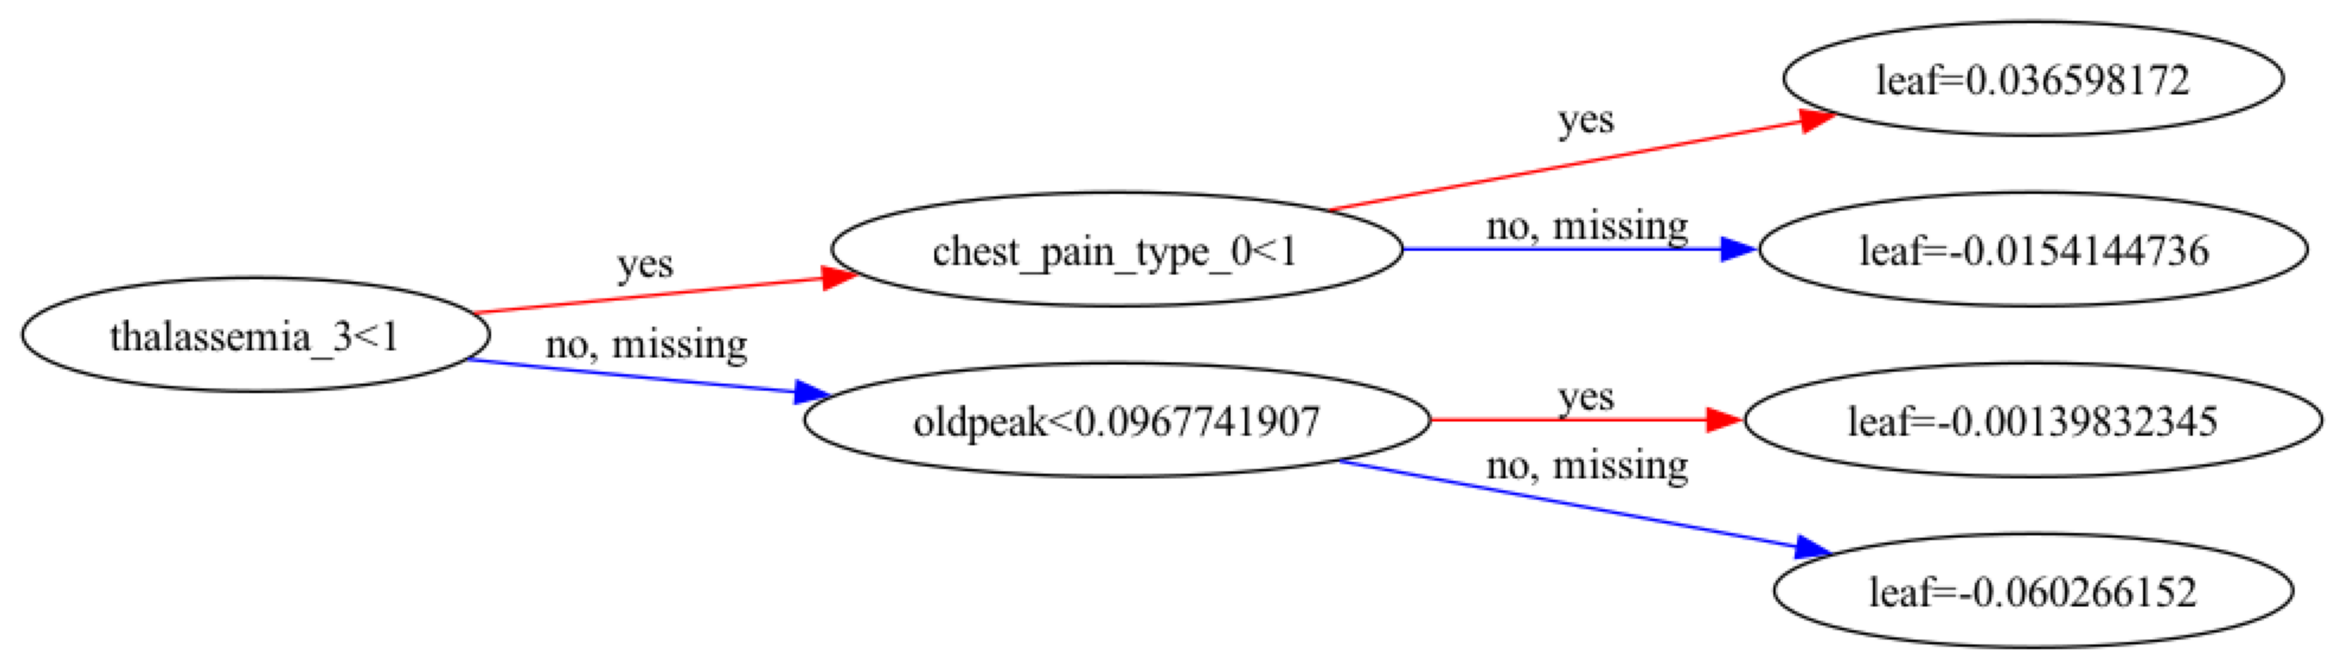

In [68]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model,num_trees=0,rankdir="LR",ax=ax)
plt.show()

# Resampled

In [69]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']

In [70]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True)
    }

    # Initialize the model with the current hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Perform cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

[I 2024-08-28 22:37:38,905] A new study created in memory with name: no-name-c342b11a-570a-4d30-bab3-ffe70509f48b
[I 2024-08-28 22:37:39,052] Trial 0 finished with value: 0.824712643678161 and parameters: {'n_estimators': 96, 'max_depth': 10, 'learning_rate': 0.12705848625247473, 'subsample': 0.9885691595100335, 'colsample_bytree': 0.7102743151935185, 'gamma': 2.3724580241229725, 'lambda': 2.7751142740279968e-06, 'alpha': 2.1126552441923387e-08}. Best is trial 0 with value: 0.824712643678161.
[I 2024-08-28 22:37:39,287] Trial 1 finished with value: 0.8171804249390456 and parameters: {'n_estimators': 262, 'max_depth': 2, 'learning_rate': 0.1567665793180283, 'subsample': 0.8029506513193941, 'colsample_bytree': 0.7580586664982303, 'gamma': 3.8110878585955725, 'lambda': 6.508864894266593, 'alpha': 8.675614662255628}. Best is trial 0 with value: 0.824712643678161.
[I 2024-08-28 22:37:39,464] Trial 2 finished with value: 0.8323754789272031 and parameters: {'n_estimators': 149, 'max_depth': 5

Best hyperparameters:  {'n_estimators': 278, 'max_depth': 4, 'learning_rate': 0.0732472340894219, 'subsample': 0.5869089760220455, 'colsample_bytree': 0.5065508222316688, 'gamma': 2.6736376054740374, 'lambda': 0.11082841730804621, 'alpha': 0.0029293660913328546}


In [71]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()



In [72]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()


In [73]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()



In [74]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

In [75]:
#test the model with the best hyperparameters
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

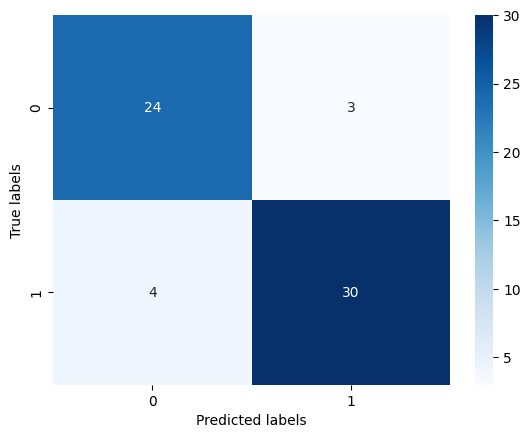

In [76]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.91      0.88      0.90        34

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61



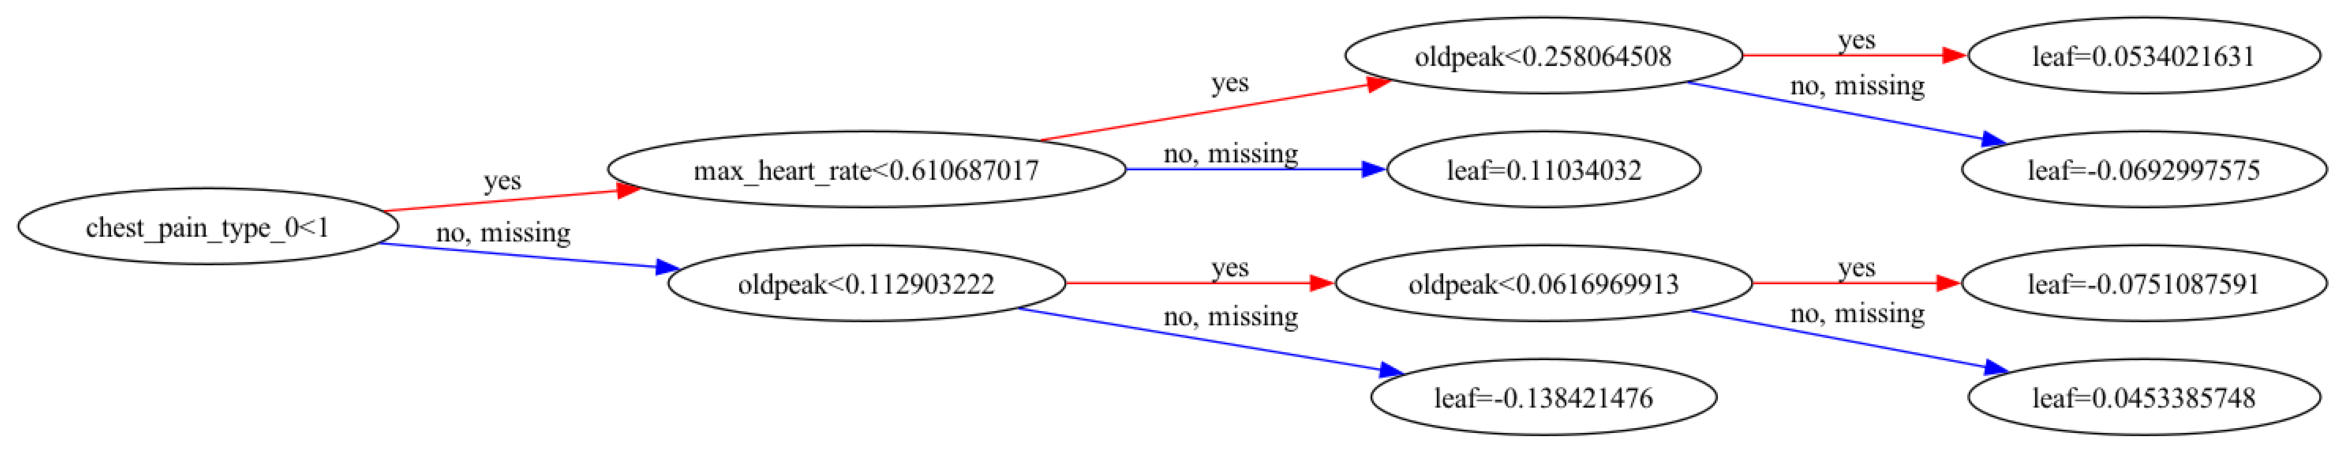

In [78]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model,num_trees=0,rankdir="LR",ax=ax)
plt.show()